# **Загрузка наших данных**

Установка pyspark с помощью pip

In [1]:
# !pip install pyspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"
import findspark
findspark.init()

In [26]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.functions import col, when, count, udf, countDistinct

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 
import pandas as pd


from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder



Создание Spark Session

In [2]:
conf = SparkConf().setAppName("Customer Churn Prediction") \
            .setMaster("local[*]") \
            .set("spark.executor.memory", "2g")

spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

Загрузка данных

In [3]:
df = spark.read.format('csv') \
    .option('inferSchema', True) \
    .option('header', True) \
    .load("C:\\Users\\fourz\\OneDrive\\Рабочий стол\\PySpark\\Customer Churn Analysis\\dataset.csv")

In [5]:
df.show(truncate=False, n=1, vertical=True)

-RECORD 0----------------------------
 customerID       | 7590-VHVEG       
 gender           | Female           
 SeniorCitizen    | No               
 Partner          | Yes              
 Dependents       | No               
 tenure           | 1                
 PhoneService     | No               
 MultipleLines    | No phone service 
 InternetService  | DSL              
 OnlineSecurity   | No               
 OnlineBackup     | Yes              
 DeviceProtection | No               
 TechSupport      | No               
 StreamingTV      | No               
 StreamingMovies  | No               
 Contract         | Month-to-month   
 PaperlessBilling | Yes              
 PaymentMethod    | Electronic check 
 MonthlyCharges   | 29.85            
 TotalCharges     | 29.85            
 Churn            | No               
only showing top 1 row



In [6]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



In [7]:
# Посмотрим размерность данных
print(f'shape: {df.count()}, {len(df.columns)}')


shape: 7043, 21


# **EDA**
- Анализ распределения
- Корреляционный анализ
- Поиск пропущенных значений

In [8]:
# Определим списки для хранения разных типов данных

string_list = []
numerical_list = []
for i, v in df.dtypes:
    if v == 'string':
        string_list.append(i)     
    else:
        numerical_list.append(i)

print(string_list)
print()
print(numerical_list)


['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

['tenure', 'MonthlyCharges', 'TotalCharges']


In [9]:
df.select(numerical_list).show(5)

+------+--------------+------------+
|tenure|MonthlyCharges|TotalCharges|
+------+--------------+------------+
|     1|         29.85|       29.85|
|    34|         56.95|      1889.5|
|     2|         53.85|      108.15|
|    45|          42.3|     1840.75|
|     2|          70.7|      151.65|
+------+--------------+------------+
only showing top 5 rows



Для дальнейшего удобства визуализации соберем наши данные в DataFrame Pandas

In [10]:
df_pandas_num = df.select(numerical_list).toPandas()
df_str_pandas = df.select(string_list).toPandas()

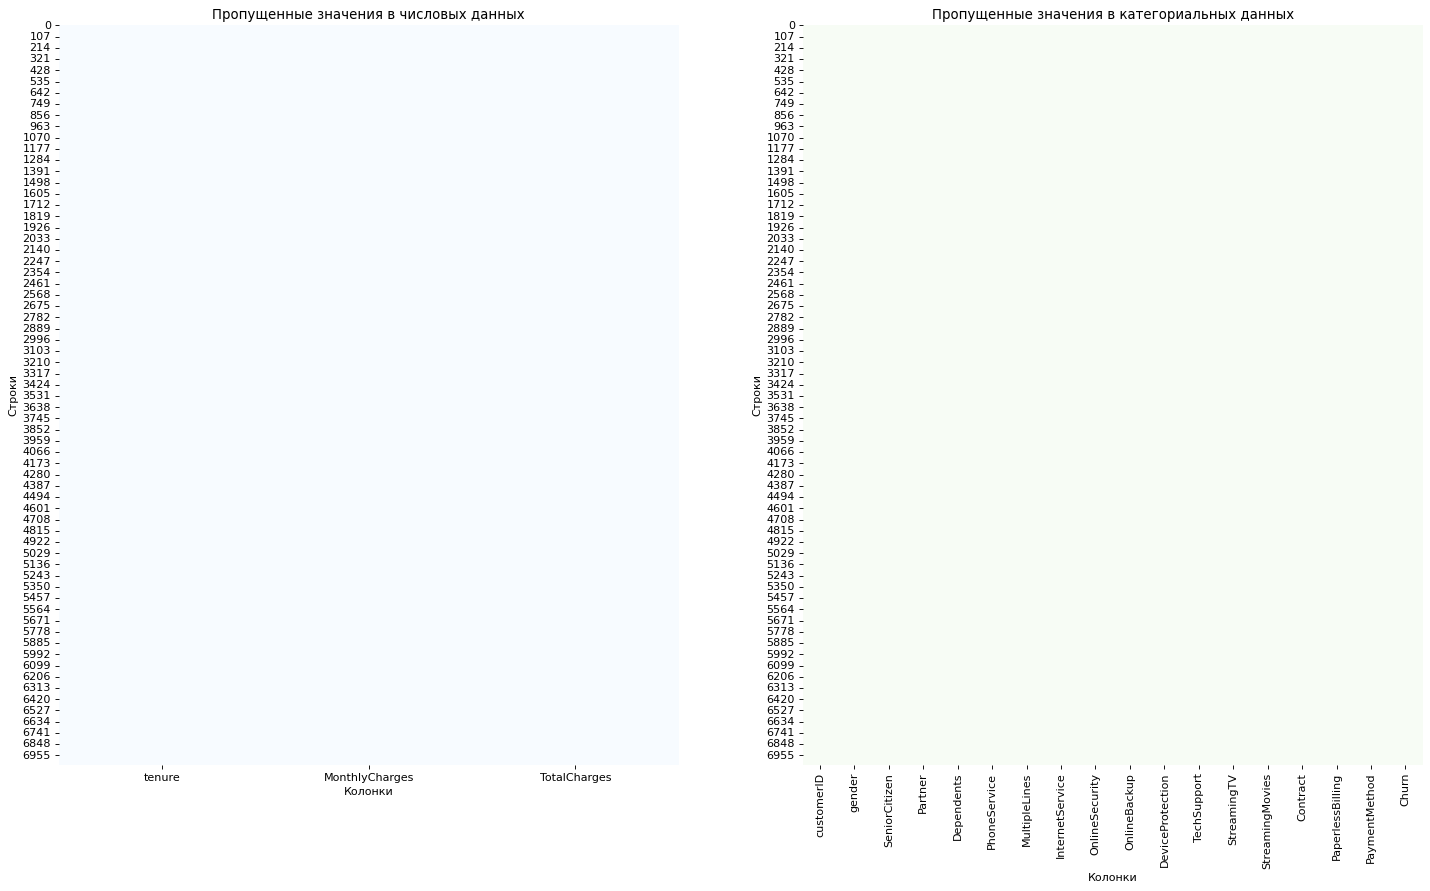

In [11]:
# Сразу посмотрим на пропущеные значения 
fig, ax = plt.subplots(1, 2, figsize=(22, 12), dpi=80, facecolor='w', edgecolor='k')

sns.heatmap(
    df_pandas_num.isna(),
    cmap="Blues",
    cbar=False,
    annot=False,
    ax=ax[0]
)
ax[0].set_title("Пропущенные значения в числовых данных")
ax[0].set_xlabel("Колонки")
ax[0].set_ylabel("Строки")

sns.heatmap(
    df_str_pandas.isna(),
    cmap="Greens",
    cbar=False,
    annot=False,
    ax=ax[1]
)
ax[1].set_title("Пропущенные значения в категориальных данных")
ax[1].set_xlabel("Колонки")
ax[1].set_ylabel("Строки")
plt.show();


Мы видим что пропущеных значений у нас только в колонке **TotalCharges**

Давайте взгялянем сколько пропущено значений

In [12]:
df.filter(col('TotalCharges').isNull()).alias('TotalCharges').count()

11

**В целом мы можем их удалить но хочется поработать с `Imputer` из модуля `pyspark.ml`**

In [13]:
# Описательная статистика
df_pandas_num.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.435752,64.761692,2283.300441
std,25.075228,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,458.000000,118.750000,8684.800000


Посмотрим как распределены числовые признаки

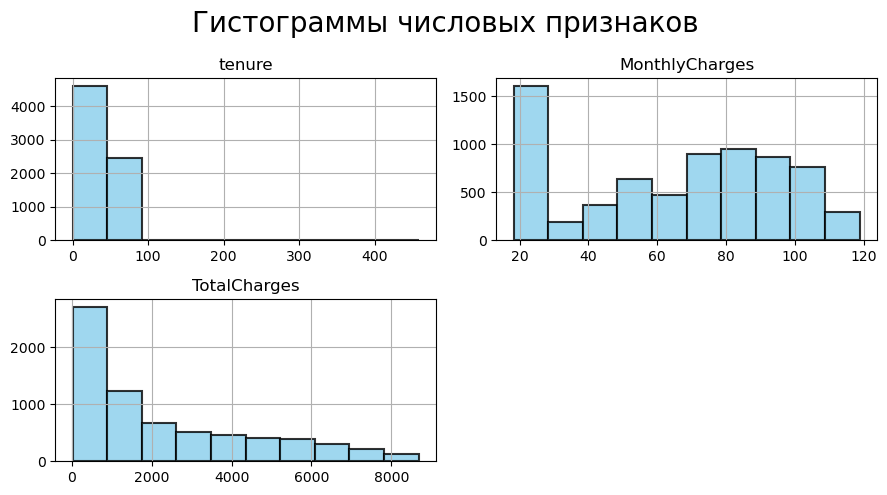

In [14]:
fig = plt.Figure(figsize=(15, 10))
ax = fig.gca()


df_pandas_num.hist(figsize=(9, 5), color='skyblue', edgecolor='black', linewidth=1.5, alpha=0.8); 
ax.set_facecolor('white')
plt.suptitle('Гистограммы числовых признаков', fontsize=20)
plt.tight_layout() 
plt.show()

Графики показывают, что распределение признака tenure содержит выбросы.

Далее посмотрим как коррелируют наши переменные 

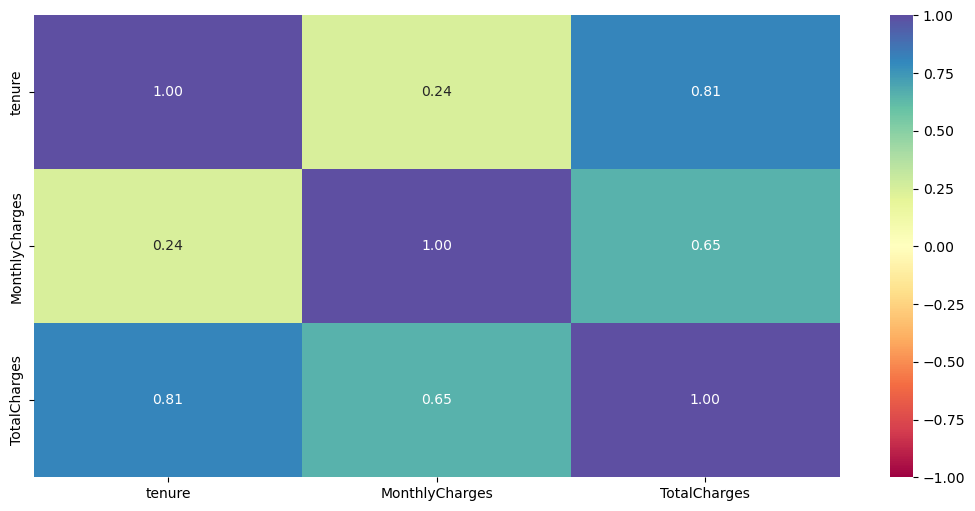

In [15]:
plt.figure(figsize=(13, 6))
sns.heatmap(df_pandas_num.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show();

In [21]:
cat_cols = [column for column, dtype in df.dtypes if dtype == 'string']

# Для каждой категориальной колонки считаем количество уникальных значений и выводим результат
for col in cat_cols:
    df.select(countDistinct(col).alias(f'Unique values in {col}')).show()


+---------------------------+
|Unique values in customerID|
+---------------------------+
|                       7043|
+---------------------------+

+-----------------------+
|Unique values in gender|
+-----------------------+
|                      2|
+-----------------------+

+------------------------------+
|Unique values in SeniorCitizen|
+------------------------------+
|                             2|
+------------------------------+

+------------------------+
|Unique values in Partner|
+------------------------+
|                       2|
+------------------------+

+---------------------------+
|Unique values in Dependents|
+---------------------------+
|                          2|
+---------------------------+

+-----------------------------+
|Unique values in PhoneService|
+-----------------------------+
|                            2|
+-----------------------------+

+------------------------------+
|Unique values in MultipleLines|
+------------------------------+
|    

# **Data Preprocessing**
- Заполнение пропущеных значений
- Удалене выбросов

**Заполнение пропущеных значений**

Так как распределение смещено вправо заполним значение медианой либо с помощью KNN Imputer

In [22]:
imputer = Imputer(inputCols=['TotalCharges'], outputCols=['TotalCharges']).setStrategy('median')
imputer = imputer.fit(df)


In [23]:
# Заполним пропуски 
data = imputer.transform(df)

Заново проверим пропущеные значения что бы понят сработал ли `Imputer` 

In [27]:
data.select(count(when(col('TotalCharges').isNull(), 'TotalCharges')).alias('TotalCharges')).show()


+------------+
|TotalCharges|
+------------+
|           0|
+------------+



**Удалим выбросы выявленные ранее на графике tenure**

In [28]:
data.select('tenure').where(data.tenure > 100).show()

+------+
|tenure|
+------+
|   458|
+------+



Всего 1 выброс поэтому смело можем его удалять

In [29]:
data = data.filter(data.tenure < 100)

# **Feature Preparation**

- Числовые признаки 
    - Vector Assembling
    - Numerical Scaling
- Категориальные признаки
    - String Indexing
    - Vector Assembling

- Объединение векторов числовых и категориальных признаков

**Подготовка признаков - Числовые признаки** <br>

`Сборка векторов --> Стандартное масштабирование` <br>

**Сборка векторов** <br>
Для применения нашей нам нужно объединить все наши числовые и категориальные признаки в векторы. Пока давайте создадим вектор признаков для наших числовых колонок.


In [30]:
numerical_list

['tenure', 'MonthlyCharges', 'TotalCharges']

In [31]:
numerical_vector_assenbler = VectorAssembler(inputCols=numerical_list, outputCol='numerical_features_vector')
data = numerical_vector_assenbler.transform(data)
data.select('numerical_features_vector').show(10)

+-------------------------+
|numerical_features_vector|
+-------------------------+
|        [1.0,29.85,29.85]|
|      [34.0,56.95,1889.5]|
|       [2.0,53.85,108.15]|
|      [45.0,42.3,1840.75]|
|        [2.0,70.7,151.65]|
|        [8.0,99.65,820.5]|
|       [22.0,89.1,1949.4]|
|       [10.0,29.75,301.9]|
|     [28.0,104.8,3046.05]|
|     [62.0,56.15,3487.95]|
+-------------------------+
only showing top 10 rows




**Масштабирование чисел** <br>
Давайте стандартизируем все наши числовые признаки.

In [32]:
scaler = StandardScaler(
    inputCol='numerical_features_vector',
    outputCol='numerical_features_scaled',
    withStd=True,
    withMean=True
)
data = scaler.fit(data).transform(data)

In [33]:
data.select('numerical_features_scaled').collect()[:2]

[Row(numerical_features_scaled=DenseVector([-1.2776, -1.1601, -0.9943])),
 Row(numerical_features_scaled=DenseVector([0.0662, -0.2595, -0.1734]))]

**Подготовка признаков - Категориальные признаки** <br>

`String Indexing --> Vector Assembling` <br>

**String Indexing** <br>
Нам нужно преобразовать все строковые колонки в числовые колонки.

In [34]:
categorical_columns_index = [name + '_Indexed' for name in string_list]


indexer = StringIndexer(
    inputCols=string_list,
    outputCols=categorical_columns_index
)

data = indexer.fit(data).transform(data)


Давайте объединим все наши категориальные признаки в один вектор признаков.

In [35]:
categorical_columns_index.remove('customerID_Indexed') # бесполезный признак
categorical_columns_index.remove('Churn_Indexed') # таргет


categorical_features_assembler = VectorAssembler(
    inputCols=categorical_columns_index,
    outputCol='Categorical_features_vector'
)

data = categorical_features_assembler.transform(data)

data.select('Categorical_features_vector').collect()[:5]

[Row(Categorical_features_vector=SparseVector(16, {0: 1.0, 2: 1.0, 4: 1.0, 5: 2.0, 6: 1.0, 8: 1.0})),
 Row(Categorical_features_vector=SparseVector(16, {6: 1.0, 7: 1.0, 9: 1.0, 13: 2.0, 14: 1.0, 15: 1.0})),
 Row(Categorical_features_vector=SparseVector(16, {6: 1.0, 7: 1.0, 8: 1.0, 15: 1.0})),
 Row(Categorical_features_vector=SparseVector(16, {4: 1.0, 5: 2.0, 6: 1.0, 7: 1.0, 9: 1.0, 10: 1.0, 13: 2.0, 14: 1.0, 15: 2.0})),
 Row(Categorical_features_vector=SparseVector(16, {0: 1.0}))]

**Объеденим числовые векторы и категориалные**

In [36]:
finall_vector_assembler = VectorAssembler(
    inputCols=[
        'Categorical_features_vector',
        'numerical_features_scaled'
    ],
    outputCol='final_features_vector'
)

data = finall_vector_assembler.transform(data)

data.select('final_features_vector').show(5)

+---------------------+
|final_features_vector|
+---------------------+
| (19,[0,2,4,5,6,8,...|
| (19,[6,7,9,13,14,...|
| (19,[6,7,8,15,16,...|
| [0.0,0.0,0.0,0.0,...|
| (19,[0,16,17,18],...|
+---------------------+
only showing top 5 rows



In [37]:
data.select('final_features_vector').collect()[:5]

[Row(final_features_vector=SparseVector(19, {0: 1.0, 2: 1.0, 4: 1.0, 5: 2.0, 6: 1.0, 8: 1.0, 16: -1.2776, 17: -1.1601, 18: -0.9943})),
 Row(final_features_vector=SparseVector(19, {6: 1.0, 7: 1.0, 9: 1.0, 13: 2.0, 14: 1.0, 15: 1.0, 16: 0.0662, 17: -0.2595, 18: -0.1734})),
 Row(final_features_vector=SparseVector(19, {6: 1.0, 7: 1.0, 8: 1.0, 15: 1.0, 16: -1.2368, 17: -0.3626, 18: -0.9597})),
 Row(final_features_vector=DenseVector([0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 2.0, 0.5141, -0.7464, -0.1949])),
 Row(final_features_vector=SparseVector(19, {0: 1.0, 16: -1.2368, 17: 0.1974, 18: -0.9405}))]

# **Обучение модели**
- Hold-out
- Создание модели
- Обучение модели
- Сделать первоначальные прогнозы с помощью модели


In [38]:
train, test = data.randomSplit(seed=42, weights=[.7, .3])

In [39]:
print(train.count())
print(test.count())

5036
2006


Тренировать будем дерево принятия решений

In [40]:
dt = DecisionTreeClassifier(
    featuresCol='final_features_vector',
    labelCol='Churn_Indexed',
    maxDepth=10
)
model = dt.fit(train)

Посмотрим на предсказания нашего дерева

In [41]:
prediction_test = model.transform(test)
prediction_test.select(['Churn', 'prediction']).show()

+-----+----------+
|Churn|prediction|
+-----+----------+
|  Yes|       0.0|
|   No|       0.0|
|   No|       1.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|  Yes|       1.0|
|  Yes|       1.0|
|   No|       0.0|
|  Yes|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
+-----+----------+
only showing top 20 rows



#  **Оценка модели**
- Вычисление площади под кривой ROC для `test` выборки
- Вычисление площади под кривой ROC для `training` выборки
- Подбор гиперпараметров

In [42]:
evaluetor = BinaryClassificationEvaluator(labelCol='Churn_Indexed')
auc_test = evaluetor.evaluate(prediction_test, {evaluetor.metricName: 'areaUnderROC'})
auc_test

0.6928233066428843

Посмотрим на AUC `training` выборки

Нужно узнать переобучаемся мы или нет

In [43]:
predictors_train = model.transform(train)
auc_train = evaluetor.evaluate(predictors_train, {evaluetor.metricName: 'areaUnderROC'})
auc_train

0.777886778516578

**Подбор гиперпараметров**

Найдем оптимальный `maxDepth` для нашего дерева. 

In [44]:
def evaluate_dt(mode_params):
    test_accuracies = []
    train_accuracies = []

    for maxD in mode_params:
        # тренируем
        decision_tree = DecisionTreeClassifier(featuresCol = 'final_features_vector', labelCol = 'Churn_Indexed', maxDepth = maxD)
        dtModel = decision_tree.fit(train)

        # оцениваем тестовую выборку
        predictions_test = dtModel.transform(test)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_Indexed")
        auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"}) 
        test_accuracies.append(auc_test)

        # оцениваем обучающую выборку
        predictions_training = dtModel.transform(train)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_Indexed")
        auc_training = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
        train_accuracies.append(auc_training)

    return(test_accuracies, train_accuracies)  

In [94]:
param = list(range(4, 27, 2))
test_accuracies, train_accuracies = evaluate_dt(param)

df_score = pd.DataFrame(
    {
        "test_accuracies": test_accuracies, 
        "train_accuracies": train_accuracies
    },
    index=param
)


In [95]:
 df_score.T

,4,6,8,10,12,14,16,18,20,22,24,26
test_accuracies,0.673419,0.760421,0.732975,0.692823,0.730344,0.707598,0.700944,0.695779,0.690883,0.690505,0.690505,0.690505
train_accuracies,0.681312,0.773432,0.751254,0.777887,0.896351,0.942557,0.974039,0.989317,0.992707,0.993679,0.993747,0.993747


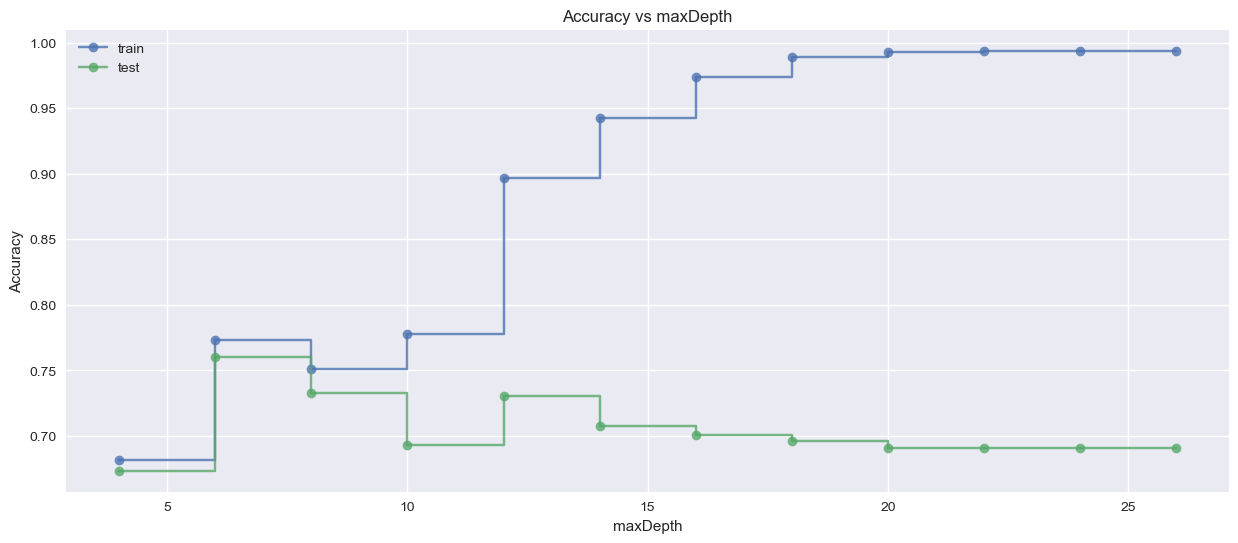

In [96]:
plt.figure(figsize=(15, 6))
plt.xlabel("maxDepth")
plt.ylabel("Аccuracy")
plt.title("Accuracy vs maxDepth")
plt.plot(param, train_accuracies, marker='o', label="train", drawstyle="steps-post", alpha=0.8)
plt.plot(param, test_accuracies, marker='o', label="test", drawstyle="steps-post", alpha=0.8)
plt.legend()
plt.show();


Заметим, что лучшее качество модели достигается при глубине дерева от 6 до 9.

Чтобы еще больше повысить эффективность нашей модели, выполним поиск по сетке параметров.

In [165]:
decision_tree = DecisionTreeClassifier(featuresCol='final_features_vector', labelCol='Churn_Indexed')


param_grid = ParamGridBuilder() \
    .addGrid(decision_tree.maxDepth, list(range(4, 27, 2))) \
    .addGrid(decision_tree.maxBins, [16, 32, 64]) \
    .addGrid(decision_tree.impurity, ["gini", "entropy"]) \
    .build()

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol='Churn_Indexed')


crossval = CrossValidator(
    estimator=decision_tree,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=5
)

cv_model = crossval.fit(train)

best_params = cv_model.bestModel.extractParamMap()
print("Лучшие параметры:")
for i, v in best_params.items():
    print(f'{i}, {v}')



Лучшие параметры:
DecisionTreeClassifier_535e7e998c71__cacheNodeIds, False
DecisionTreeClassifier_535e7e998c71__checkpointInterval, 10
DecisionTreeClassifier_535e7e998c71__featuresCol, final_features_vector
DecisionTreeClassifier_535e7e998c71__impurity, gini
DecisionTreeClassifier_535e7e998c71__labelCol, Churn_Indexed
DecisionTreeClassifier_535e7e998c71__leafCol, 
DecisionTreeClassifier_535e7e998c71__maxBins, 16
DecisionTreeClassifier_535e7e998c71__maxDepth, 6
DecisionTreeClassifier_535e7e998c71__maxMemoryInMB, 256
DecisionTreeClassifier_535e7e998c71__minInfoGain, 0.0
DecisionTreeClassifier_535e7e998c71__minInstancesPerNode, 1
DecisionTreeClassifier_535e7e998c71__minWeightFractionPerNode, 0.0
DecisionTreeClassifier_535e7e998c71__predictionCol, prediction
DecisionTreeClassifier_535e7e998c71__probabilityCol, probability
DecisionTreeClassifier_535e7e998c71__rawPredictionCol, rawPrediction
DecisionTreeClassifier_535e7e998c71__seed, 7948698868042667494


In [45]:
decision_tree = DecisionTreeClassifier(
    featuresCol='final_features_vector',
    labelCol='Churn_Indexed',
    impurity='gini',
    maxBins=16,
    maxDepth=6
)

dtModel = decision_tree.fit(train)

predictions_test = dtModel.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol="Churn_Indexed")
auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"}) 
print(auc_test)

0.7627186774979483


   Так как задали немного параметров сильных улучшений мы не получили 
    поэтому перейдем к **Feature Impotarnces**

# **Feature Impotarnces**


Определим, какие признаки имеют наибольшее влияние на уход клиентов.

In [46]:
feature_impotarnces = dtModel.featureImportances
scores = [score for i, score in enumerate(feature_impotarnces)]
df_features = pd.DataFrame(scores, columns=['score'], index=categorical_columns_index + numerical_list)
df_features

,score
gender_Indexed,0.032629
SeniorCitizen_Indexed,0.016864
Partner_Indexed,0.020378
Dependents_Indexed,0.016451
PhoneService_Indexed,0.010518
MultipleLines_Indexed,0.014318
InternetService_Indexed,0.089774
OnlineSecurity_Indexed,0.030045
OnlineBackup_Indexed,0.018950
DeviceProtection_Indexed,0.017576


давайте визуализируем результат

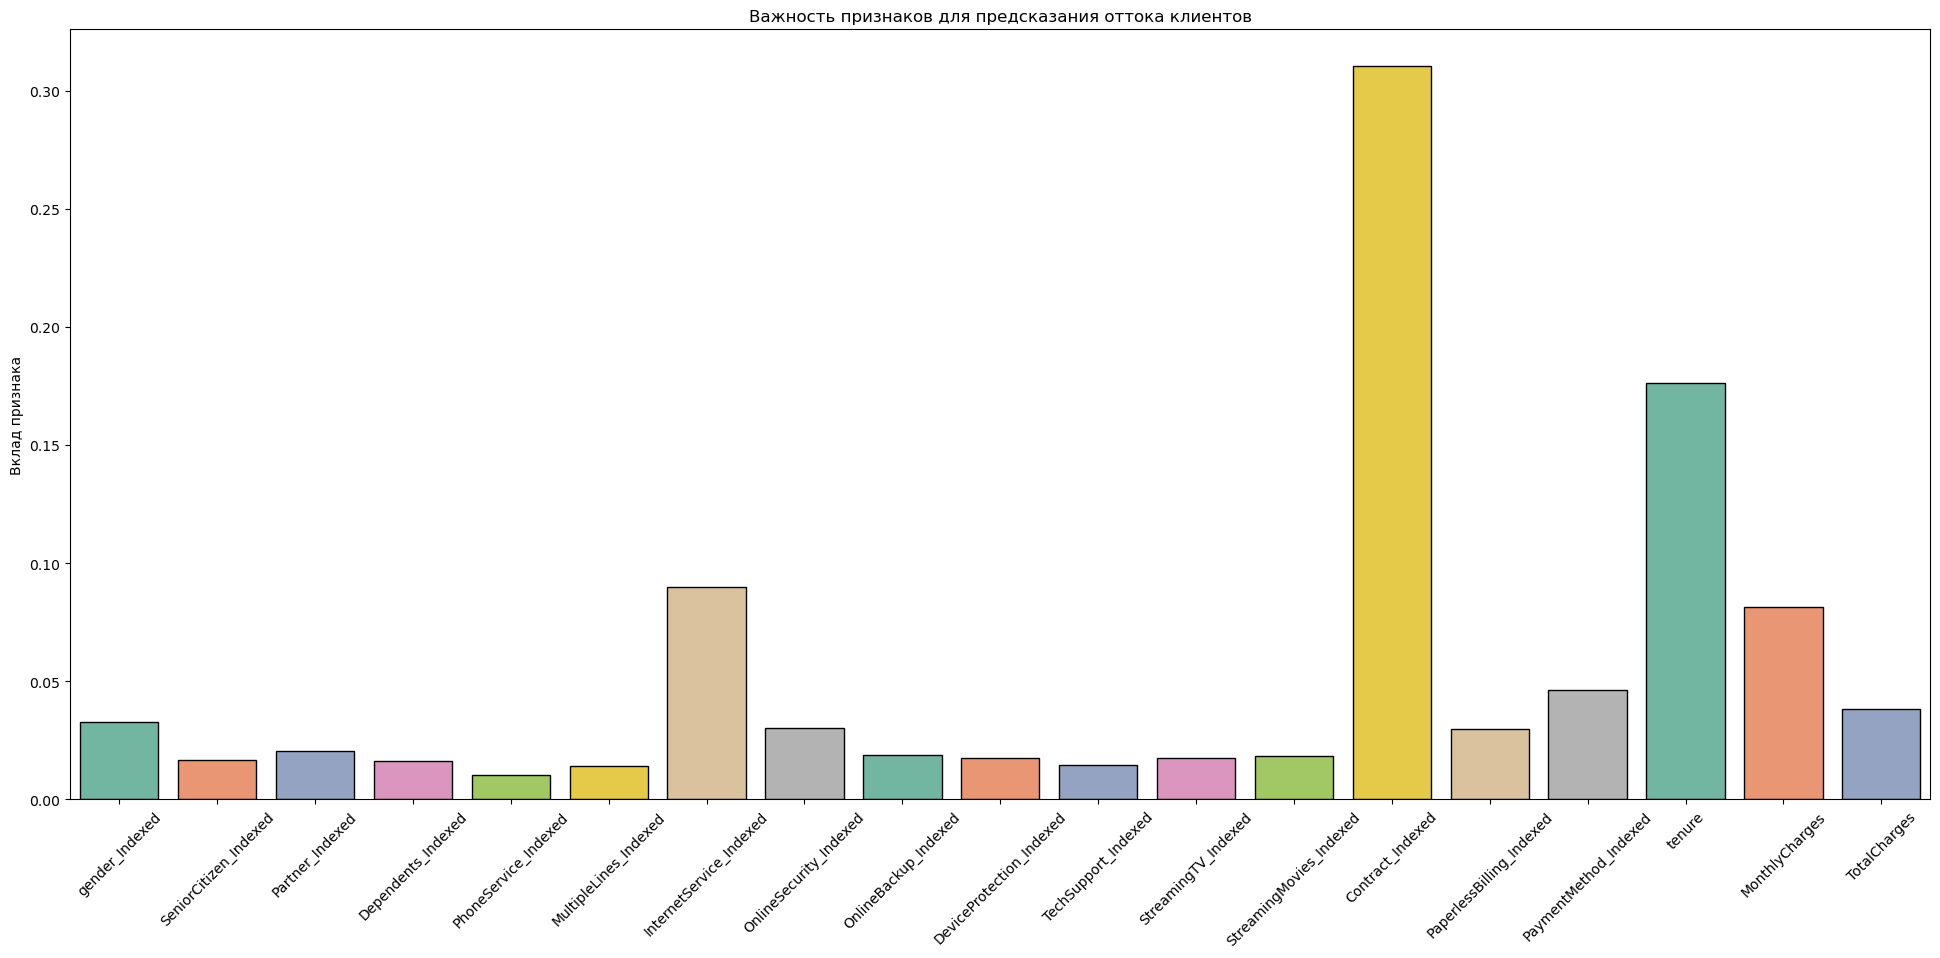

In [47]:
plt.figure(figsize=(24, 10))
sns.barplot(data=df_features.T, palette="Set2", edgecolor="black")

# Добавляем заголовок и подписи осей
plt.title("Важность признаков для предсказания оттока клиентов")
plt.ylabel("Вклад признака")
plt.xticks(rotation=45)
plt.show();



In [48]:
df_Contract = data.groupby(['Contract', 'Churn']).count().toPandas()

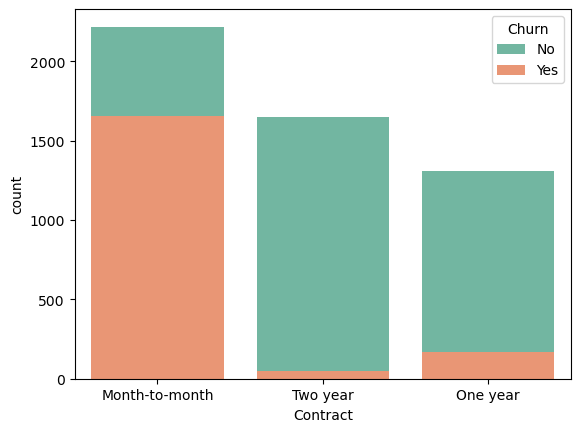

In [49]:
sns.barplot(data=df_Contract, x='Contract', y='count', hue='Churn', palette='Set2', dodge=False);

На столбчатой диаграмме отображается количество привлеченных клиентов в зависимости от типа их контракта. Очевидно, что клиенты с контрактом "от месяца к месяцу" имеют более высокий уровень оттока по сравнению с клиентами с контрактами "на один год" или "на два года". В качестве рекомендации телекоммуникационная компания могла бы рассмотреть возможность предоставления льгот или скидок, чтобы побудить клиентов с ежемесячными контрактами переходить на более долгосрочные контракты.

# CatBoost Spark
- Перейдем к созданию более мощного алгоритма